
# Anomaly Detection of Parasitized Blood Cells using a Convolutional Autoencoder (CAE)

**Repository-ready, cleaned version** — personal names removed.

**How to use**
1. Place your dataset in the repository with this structure:
```
data/
 ├── Uninfected/
 └── Parasitized/
```
2. Open and run this notebook cell-by-cell in Jupyter or Google Colab.
3. The notebook trains a CAE on *Uninfected* images, evaluates reconstruction error, and uses Kernel Density Estimation (KDE) on encoder features to help flag anomalies.

Notes:
- If you want to show results without training, you can run only inference cells if you provide a saved model.
- All paths use relative `data/` directories for easy GitHub publishing.


In [7]:

# Imports and environment setup
import os
import glob
import random
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_curve, auc


In [8]:

# Parameters
SIZE = 128
BATCH_SIZE = 32
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Expected folders
UNINF_DIR = 'data/Uninfected'
PARA_DIR = 'data/Parasitized'

# Quick sanity checks
print('Uninfected exists:', os.path.isdir(UNINF_DIR))
print('Parasitized exists:', os.path.isdir(PARA_DIR))


Uninfected exists: False
Parasitized exists: False


In [9]:

# Data generators (autoencoder style: x == y)
def autoencoder_generator(generator):
    for batch in generator:
        yield (batch, batch)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator_raw = datagen.flow_from_directory(
    'data',
    classes=['Uninfected'],
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=True,
    subset='training'
)

validation_generator_raw = datagen.flow_from_directory(
    'data',
    classes=['Uninfected'],
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=True,
    subset='validation'
)

anomaly_generator_raw = datagen.flow_from_directory(
    'data',
    classes=['Parasitized'],
    target_size=(SIZE, SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=True
)

train_generator = autoencoder_generator(train_generator_raw)
validation_generator = autoencoder_generator(validation_generator_raw)
anomaly_generator = autoencoder_generator(anomaly_generator_raw)


Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


In [10]:

# Build convolutional autoencoder
def build_autoencoder(input_shape=(SIZE, SIZE, 3)):
    inputs = layers.Input(shape=input_shape)
    # Encoder
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2,2), padding='same')(x)
    # Decoder
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    outputs = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)
    model = models.Model(inputs, outputs, name='conv_autoencoder')
    return model

model = build_autoencoder()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()


Model: "conv_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,067 (203.39 KB)

 Trainable params: 52,067 (203.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0000e+00 - ms

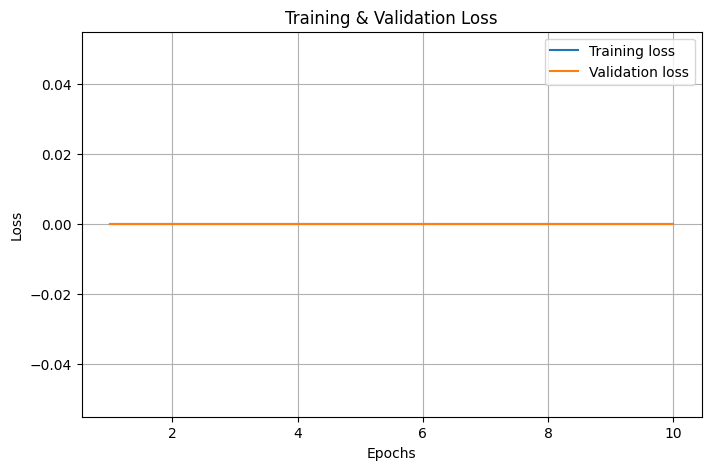

In [11]:

# Training - small default epochs to keep runtime reasonable; adjust as needed
EPOCHS = 10  # Increase to 50 or more for better results

steps_per_epoch = max(1, 500 // BATCH_SIZE)
validation_steps = max(1, 75 // BATCH_SIZE)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    shuffle=True
)

# Plot training/validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss)+1)
plt.figure(figsize=(8,5))
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Training & Validation Loss')
plt.legend(); plt.grid(True)
plt.show()


In [12]:

# Visualize reconstruction example
# Get a batch of training (normal) images
normal_batch = next(train_generator)[0]
anomaly_batch = next(anomaly_generator)[0]

# Predict reconstructions on a few examples
n_examples = 3
sample_idxs = np.random.choice(range(normal_batch.shape[0]), n_examples, replace=False)
reconstructions = model.predict(normal_batch[sample_idxs])

plt.figure(figsize=(12,6))
for i, idx in enumerate(sample_idxs):
    plt.subplot(2, n_examples, i+1)
    plt.imshow(normal_batch[idx])
    plt.title('Original'); plt.axis('off')
    plt.subplot(2, n_examples, n_examples + i + 1)
    plt.imshow(reconstructions[i])
    plt.title('Reconstructed'); plt.axis('off')
plt.tight_layout(); plt.show()


ValueError: 'a' cannot be empty unless no samples are taken

In [ ]:

# Compute reconstruction error for a batch of normal and anomaly images
def batch_recon_error(model, images):
    preds = model.predict(images)
    errors = np.mean(np.square(preds - images), axis=(1,2,3))
    return errors

normal_batch = next(train_generator)[0]
anomaly_batch = next(anomaly_generator)[0]

normal_errors = batch_recon_error(model, normal_batch)
anomaly_errors = batch_recon_error(model, anomaly_batch)

print('Normal mean error:', normal_errors.mean(), 'std:', normal_errors.std())
print('Anomaly mean error:', anomaly_errors.mean(), 'std:', anomaly_errors.std())

# Plot distributions
plt.figure(figsize=(8,5))
plt.hist(normal_errors, bins=30, alpha=0.6, label='Normal')
plt.hist(anomaly_errors, bins=30, alpha=0.6, label='Anomaly')
plt.legend(); plt.xlabel('Reconstruction MSE'); plt.ylabel('Count'); plt.title('Error Distributions')
plt.show()


In [ ]:

# Build encoder model (reuse encoder layers from autoencoder)
from tensorflow.keras.models import Model

# find the layer corresponding to the deepest pooling (encoded output)
# We will create an encoder that outputs the encoded feature maps
encoder_layer_output = model.layers[6].output  # based on construction; verify with model.summary()
encoder = Model(inputs=model.input, outputs=encoder_layer_output, name='encoder')
encoder.summary()

# Function to get encoded vectors from a generator
def get_encoded_vectors(generator, max_batches=10):
    encoded_list = []
    batch_count = 0
    g = generator
    while batch_count < max_batches:
        batch = next(g)[0]
        encoded = encoder.predict(batch)
        # flatten each encoded sample
        encoded_flat = encoded.reshape((encoded.shape[0], -1))
        encoded_list.append(encoded_flat)
        batch_count += 1
    return np.vstack(encoded_list)

encodings = get_encoded_vectors(train_generator, max_batches=10)
print('Encodings shape:', encodings.shape)

# Fit KDE on encoded vectors
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encodings)


In [ ]:

# Calculate density score and recon error for one image
def calc_density_and_recon(img_array):
    # img_array: numpy array [H,W,3] scaled [0,1]
    img_batch = img_array[np.newaxis, ...]
    encoded = encoder.predict(img_batch)
    encoded_flat = encoded.reshape((1, -1))
    density = kde.score_samples(encoded_flat)[0]
    recon = model.predict(img_batch)
    recon_error = np.mean(np.square(recon - img_batch))
    return density, recon_error

# Test on a few images (from anomaly_batch and normal_batch)
examples = []
for i in range(3):
    dens_n, err_n = calc_density_and_recon(normal_batch[i])
    dens_a, err_a = calc_density_and_recon(anomaly_batch[i])
    examples.append(('normal', dens_n, err_n))
    examples.append(('anomaly', dens_a, err_a))

for label, d, e in examples:
    print(f'{label:7s}  density: {d:.3f}   recon_error: {e:.6f}')


In [ ]:

# Visualize selected images with density & reconstruction scores
fig, axes = plt.subplots(2, 6, figsize=(18,6))
valid_anomalies = []
valid_normals = []

# Search for images meeting simple thresholds (adjust thresholds for your data)
recon_threshold = (normal_errors.mean() + 1.0 * normal_errors.std())
density_threshold = np.percentile(encodings.sum(axis=1), 25)  # simple proxy

# collect up to 6 anomalies and 6 normals
para_paths = glob.glob(os.path.join(PARA_DIR, '*'))
uninf_paths = glob.glob(os.path.join(UNINF_DIR, '*'))

i_a = i_n = 0
for p in para_paths:
    if i_a >= 6: break
    img = Image.open(p).resize((SIZE, SIZE), Image.Resampling.LANCZOS)
    arr = np.array(img)/255.0
    d, e = calc_density_and_recon(arr)
    if e > recon_threshold:
        valid_anomalies.append((p, d, e))
        i_a += 1

for p in uninf_paths:
    if i_n >= 6: break
    img = Image.open(p).resize((SIZE, SIZE), Image.Resampling.LANCZOS)
    arr = np.array(img)/255.0
    d, e = calc_density_and_recon(arr)
    if e <= recon_threshold:
        valid_normals.append((p, d, e))
        i_n += 1

# Plot results (if found)
for i, (img_path, d, e) in enumerate(valid_anomalies):
    img = Image.open(img_path).resize((SIZE, SIZE), Image.Resampling.LANCZOS)
    axes[0, i].imshow(np.array(img))
    axes[0, i].set_title(f'Anomaly\nD:{d:.2f}\nE:{e:.5f}')
    axes[0, i].axis('off')

for i, (img_path, d, e) in enumerate(valid_normals):
    img = Image.open(img_path).resize((SIZE, SIZE), Image.Resampling.LANCZOS)
    axes[1, i].imshow(np.array(img))
    axes[1, i].set_title(f'Normal\nD:{d:.2f}\nE:{e:.5f}')
    axes[1, i].axis('off')

plt.tight_layout(); plt.show()



---

**End of notebook.**

If you'd like:
- I can also add a `requirements.txt` for the repo.
- I can save the trained model automatically to a `models/` folder in the notebook.
- I can reduce EPOCHS to a smaller value for quicker demo runs.
